In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,8]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
sns.set()

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [3]:
#import spacy
#import torchtext
#from textblob import TextBlob
#nlp = spacy.load(r'en_core_web_lg\en_core_web_lg-3.4.1')

In [4]:
df = pd.read_csv(r"C:\Users\besho\Downloads\nyc-taxi-trip\train\train.csv")
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.isna().sum() , df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


(id                    0
 vendor_id             0
 pickup_datetime       0
 dropoff_datetime      0
 passenger_count       0
 pickup_longitude      0
 pickup_latitude       0
 dropoff_longitude     0
 dropoff_latitude      0
 store_and_fwd_flag    0
 trip_duration         0
 dtype: int64,
 None)

In [6]:
df["td_minutes"] = df["trip_duration"]/60

### General Simple Exploration First To Get Sense of the data

In [7]:
# Check If There Any Difference Between Vendors According To Trip_Duration Distribution 
df[df['vendor_id'] == 1]['td_minutes'].describe()

count    678342.000000
mean         14.090637
std         102.465185
min           0.016667
25%           6.583333
50%          10.966667
75%          17.800000
max       58771.366667
Name: td_minutes, dtype: float64

In [8]:
df[df['vendor_id'] == 2]['td_minutes'].describe()

count    780302.000000
mean         17.644053
std          71.488115
min           0.016667
25%           6.650000
50%          11.100000
75%          18.033333
max        1439.866667
Name: td_minutes, dtype: float64

In [9]:
df['td_minutes'].describe()

count    1.458644e+06
mean     1.599154e+01
std      8.729053e+01
min      1.666667e-02
25%      6.616667e+00
50%      1.103333e+01
75%      1.791667e+01
max      5.877137e+04
Name: td_minutes, dtype: float64

In [10]:
np.percentile(df["td_minutes"].values , 99)

57.333333333333336

#### We Can Conclude Some Information From Basic Exploration Here  <pre>
1. Mean Value Here is Useless So we have to look to Median Instead ,This Happen by the effect of the "outliers"
2. We Need To Remove "Outliers" Because Absolutely Any Trip  > 60 Minutes Does Not Expresses The Distribution
3. std alse meaningless because the influence of outliers , you can notice that by looking to above 2 describe function in both classes in "vendor_id" .

In [11]:
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [12]:
for i in df['passenger_count'].value_counts().index:
    print(f"mean of trip duration with {i} passengers is {df[df['passenger_count']==i]['td_minutes'].mean()}")

mean of trip duration with 1 passengers is 15.506662554586068
mean of trip duration with 2 passengers is 16.75763890870034
mean of trip duration with 5 passengers is 17.83720289929344
mean of trip duration with 3 passengers is 17.13727127020161
mean of trip duration with 6 passengers is 17.689253718991345
mean of trip duration with 4 passengers is 17.558829155517977
mean of trip duration with 0 passengers is 28.640555555555544
mean of trip duration with 7 passengers is 0.3277777777777778
mean of trip duration with 9 passengers is 9.333333333333334
mean of trip duration with 8 passengers is 1.7333333333333334


In [13]:
df[df["passenger_count"] ==0 ]['td_minutes'].sort_values(ascending = False)[:10]

62744      1431.683333
676906       54.050000
217765       37.516667
1257574      36.516667
301600       34.533333
412172       25.933333
796361       18.683333
777319       17.150000
1433427      16.350000
919750       10.016667
Name: td_minutes, dtype: float64

##### Now we can remove the outliers safely 

## Feature Engineering

In [14]:
df.shape , np.percentile(df['td_minutes'] , 99)

((1458644, 12), 57.333333333333336)

In [15]:
df = df[df['td_minutes'] < np.percentile(df['td_minutes'] , 99)]

In [16]:
df.shape , df['td_minutes'].describe()

((1444051, 12),
 count    1.444051e+06
 mean     1.345759e+01
 std      9.590334e+00
 min      1.666667e-02
 25%      6.583333e+00
 50%      1.093333e+01
 75%      1.763333e+01
 max      5.731667e+01
 Name: td_minutes, dtype: float64)

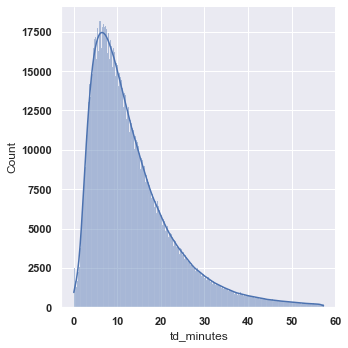

In [17]:
# Look For Trip Distribution
sns.displot(data=df , x = "td_minutes" , kde = True )

##### As you can see , the trip_duration is Right Skewed , so from now we will use Median instead of Mean 

In [18]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,td_minutes
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000


In [19]:
# i found this on internet ->Saturday AND Sunday are both the ‘weekend’ when many people don’t have to work.
# so,i will make a "Is_Weekend" Feature ,that's under assumption that if there is no work the street will no be crowded

def get_Features_From_Date(df): 
    # i do it as a function instead of writing some lines as above , because i will use it again in test data
    # Do Not Violate DRY -> Don't Repeat Yourself
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x : 1 if x>4 else 0)

get_Features_From_Date(df)

In [20]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,td_minutes,month,day,day_of_week,is_weekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,3,14,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,6,12,6,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,1,19,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,4,6,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,3,26,5,1


In [21]:
def convert_storeAndFwd(df):
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].apply(lambda x : 1 if x =='Y' else 0)
convert_storeAndFwd(df)

In [22]:
df.drop(columns=['id','pickup_datetime' , 'dropoff_datetime', 'td_minutes'] , inplace = True)
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,day_of_week,is_weekend
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,0,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,6,1
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,1,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,2,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,5,1


In [23]:
from math import radians, cos, sin, asin, sqrt
def distace_between_two_points(data):
    distance = []
    for i in data.iterrows():
        
        lon1 , lat1 , lon2 , lat2 = i[1][2:6].values
        lon1 = radians(lon1)
        lon2 = radians(lon2)
        lat1 = radians(lat1)
        lat2 = radians(lat2)

        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

        c = 2 * asin(sqrt(a))
        r = 6371
        
        distance.append(c * r)
    data['distance'] = distance 
distace_between_two_points(df)

In [24]:
df['trip_duration'] = np.log(df['trip_duration'])

In [25]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,day_of_week,is_weekend,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,6.120297,3,14,0,0,1.498521
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6.496775,6,12,6,1,1.805507
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661056,1,19,1,0,6.385098
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,6.061457,4,6,2,0,1.485498
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,6.075346,3,26,5,1,1.188588


### Vanilla Machine Learning Model

In [26]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [44]:
X = df.drop(columns = 'trip_duration').values
y = df['trip_duration'].values

model = LGBMRegressor(n_estimators=888)
model.fit(X,y)

LGBMRegressor(n_estimators=888)

In [45]:
test_data = pd.read_csv(r"C:\Users\besho\Downloads\nyc-taxi-trip\test\test.csv")
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [46]:
get_Features_From_Date(test_data)
convert_storeAndFwd(test_data)
test_data.drop(columns=['id','pickup_datetime'] , inplace = True)
distace_between_two_points(test_data)
test_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,day,day_of_week,is_weekend,distance
0,1,1,-73.988129,40.732029,-73.990173,40.756680,0,6,30,3,0,2.746426
1,1,1,-73.964203,40.679993,-73.959808,40.655403,0,6,30,3,0,2.759239
2,1,1,-73.997437,40.737583,-73.986160,40.729523,0,6,30,3,0,1.306155
3,2,1,-73.956070,40.771900,-73.986427,40.730469,0,6,30,3,0,5.269088
4,1,1,-73.970215,40.761475,-73.961510,40.755890,0,6,30,3,0,0.960842


In [47]:
hold = pd.read_csv(r"C:\Users\besho\Downloads\nyc-taxi-trip\test\test.csv")
submit = pd.DataFrame()
submit['id'] = hold['id']
submit['trip_duration'] = np.exp(model.predict(test_data.values))
submit.head()

,id,trip_duration
0,id3004672,1011.243623
1,id3505355,686.960675
2,id1217141,492.829587
3,id2150126,1026.858507
4,id1598245,403.027521


In [48]:
submit.to_csv("final_submit.csv" , index=False)

In [28]:
class New_York(Dataset):
    
    def __init__(self ,x ,y):
        self.x = torch.tensor(x ,dtype = torch.float32).to('cuda')
        self.y = torch.tensor(y , dtype = torch.float32).to('cuda')
        self.n_samples = len(self.y)
    
    def __getitem__(self , index):
        return self.x[index] , self.y[index]
    
    def __len__(self):
        return self.n_samples

In [29]:
X_train , X_valid , y_train , y_valid = train_test_split(X, y , test_size = 0.1)
train_data = New_York(X_train , y_train)
valid_data = New_York(X_valid , y_valid)
train_dataloader = DataLoader(dataset= train_data , batch_size = 1024 , shuffle = True )
valid_dataloader = DataLoader(dataset = valid_data , batch_size = 256 , shuffle = True)

In [30]:
class ANN(nn.Module):
    def __init__(self , input_size):
        super().__init__()
        self.layers = nn.Sequential(
            
        nn.Linear(12 , 50),
        nn.ReLU(),
        
        nn.Linear(50 , 50) ,
        nn.ReLU(),
        
        nn.Linear(50, 100),
        nn.ReLU(),
        
        nn.Linear(100, 32),
        nn.ReLU(),
        nn.Dropout(0.2)

        )
        
        self.end_layer = nn.Linear(32,1)
        
    def forward(self , x ,is_NN):
        x = self.layers(x)
        if(is_NN == 0):
            return x
        
        return self.end_layer(x)
model = ANN(12).to('cuda')
model(torch.randn(1000,12).to('cuda') , 1).shape

torch.Size([1000, 1])

In [31]:
from tqdm.auto import tqdm
loss = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters() , lr = 0.001)
epochs = 25


In [32]:
def test_step(valid_dataloader):
    ts_loss = 0
    model.eval()
    with torch.inference_mode():
        for x,y in valid_dataloader:
            test_pred = model(x ,1)
            test_loss = loss(test_pred , y)
            ts_loss += test_loss
        ts_loss /= len(valid_dataloader)
    
    return test_pred , ts_loss
           


In [33]:
def train_step(train_dataloader , valid_dataloader):
    
    all_train_loss = []
    for epoch in tqdm(range(epochs)):
        model.train()
        tr_loss =  0
        for x,y in train_dataloader:
            y_pred = model(x ,1)
            train_loss = loss(y_pred , y)
            tr_loss += train_loss
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        tr_loss /= len(train_dataloader)
        all_train_loss.append(tr_loss)
        
        if(valid_dataloader):
            _ , ts_loss = test_step(valid_dataloader)
            print(f'train loss = {tr_loss} | valid loss = {ts_loss}')
            continue
  
        print(f'train loss = {tr_loss}' )

In [34]:
all_data = New_York(X , y)
train_dataloader = DataLoader(dataset= all_data , batch_size = 1024 , shuffle = True )

In [35]:
train_step(train_dataloader , 0)

  0%|          | 0/25 [00:00<?, ?it/s]

train loss = 1.4397470951080322
train loss = 1.120599389076233
train loss = 0.9954544305801392
train loss = 0.8650766611099243
train loss = 0.7675321102142334
train loss = 0.6933459639549255
train loss = 0.6413866281509399
train loss = 0.6091805696487427
train loss = 0.5922571420669556
train loss = 0.584617018699646
train loss = 0.5818697810173035
train loss = 0.581139862537384
train loss = 0.5808651447296143
train loss = 0.5808865427970886
train loss = 0.5807730555534363
train loss = 0.5809219479560852
train loss = 0.5807520151138306
train loss = 0.5807904005050659
train loss = 0.580839216709137
train loss = 0.5808780789375305
train loss = 0.5808009505271912
train loss = 0.5807929635047913
train loss = 0.5808640718460083
train loss = 0.5807945132255554
train loss = 0.5807670950889587
